### Generate the UI data for the modeling case for demo

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from sklearn.cluster import DBSCAN
from scipy.stats import wasserstein_distance, binned_statistic
from decimal import Decimal, ROUND_HALF_UP
import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../../'
sys.path.append(os.path.join(ppath, 'code/framework'))
from discretizers import *
from framework_utils import *
from SearchSpace import *
ppath = sys.path[0] + '/../../'

/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(CVXPY) Jan 30 12:54:51 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 30 12:54:51 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
def get_points(partitions, semantic_metric) -> List:
    if semantic_metric == 'l2_norm':
        semantics = [p.l2_norm for p in partitions]
    elif semantic_metric == 'gpt_distance':
        semantics = [p.gpt_distance for p in partitions]
    elif semantic_metric == 'KLDiv':
        semantics = [p.KLDiv for p in partitions]
    else: raise ValueError("Invalid semantic metric")
    utility = [p.utility for p in partitions]
    datapoints = [np.array(semantics), np.array(utility)]
    return datapoints

def linkage_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    t = parameters['t']
    criterion = parameters['criterion']
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    Z = linkage(X, method='ward')
    #fig = plt.figure(figsize=(25, 10))
    #dn = dendrogram(Z, color_threshold=t)
    agg_clusters = fcluster(Z, t=t, criterion=criterion)
    #agg_clusters = fcluster(Z, t=0.5, criterion='distance')
    agg_clusters = [x-1 for x in agg_clusters] # 0-indexing
    return agg_clusters

def DBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    eps = parameters['eps']
    min_samples = parameters['min_samples']
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    dbscan_clusters = model.fit_predict(X)
    # For outliers, assign them to each of their separate cluster
    max_cluster = np.max(dbscan_clusters)
    for i, c in enumerate(dbscan_clusters):
        if c == -1:
            dbscan_clusters[i] = max_cluster + 1
            max_cluster += 1
    return dbscan_clusters

def HDBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    min_cluster_size = parameters['min_cluster_size']
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=min_cluster_size)
    hdbscan_clusters = model.fit_predict(X)
    # For outliers, assign them to each of their separate cluster
    max_cluster = np.max(hdbscan_clusters)
    for i, c in enumerate(hdbscan_clusters):
        if c == -1:
            hdbscan_clusters[i] = max_cluster + 1
            max_cluster += 1
    return hdbscan_clusters

def find_actual_cluster_sample_size(total_budget, norm_inv_probs, cluster_sizes):

    # Step 3: Calculate the ideal number of samples for each cluster
    # Based on the inverse probabilities and total budget
    ideal_samples = [int(p * total_budget) for p in norm_inv_probs]
    ideal_excess = sum(ideal_samples) - total_budget
    #print("Inv probs:", norm_inv_probs)
    #print("Ideal samples:", ideal_samples)

    # Step 4: Initialize an array to track the actual samples drawn from each cluster
    actual_samples = [0] * len(norm_inv_probs)

    # Step 5: First pass: Assign as many samples as possible without exceeding cluster capacity
    excess_budget = 0  # Track how much of the budget is left after clusters with limited points
    for i in range(len(norm_inv_probs)):
        if ideal_samples[i] <= cluster_sizes[i]:
            # We can sample the ideal number from this cluster
            actual_samples[i] = ideal_samples[i]
        else:
            # Not enough points in this cluster, so sample all available points
            actual_samples[i] = cluster_sizes[i]
            # Add the remaining unused budget
            excess_budget += ideal_samples[i] - cluster_sizes[i]
    if ideal_excess < 0: excess_budget -= ideal_excess
    #print("Excess budget:", excess_budget)
    
    # Step 6: Redistribute the excess budget
    # Only distribute to clusters that still have points left to sample
    prev_excess_budget = 0
    remaining_inv_probs, remaining_inv_sum = [], 0
    clusters = [i for i in range(len(cluster_sizes))]
    while excess_budget > 0 and excess_budget != prev_excess_budget:
        #print("Excess budget:", excess_budget)
        remaining_inv_probs = [inv_p if actual_samples[i] < cluster_sizes[i] else 0 for i, inv_p in enumerate(norm_inv_probs)]
        remaining_inv_sum = sum(remaining_inv_probs)
        #print("Remaining inv probs:", np.array(remaining_inv_probs) / remaining_inv_sum)
        # remove clusters that have been fully sampled
        clusters = [i for i in range(len(cluster_sizes)) if remaining_inv_probs[i] > 0]
        remaining_inv_probs = [inv_p for i, inv_p in enumerate(remaining_inv_probs) if inv_p > 0]
        
        if remaining_inv_sum == 0:
            break  # No more clusters to redistribute to
        
        additionals = [0] * len(norm_inv_probs)
        samples = np.random.choice(clusters, p=np.array(remaining_inv_probs)/remaining_inv_sum, size=excess_budget)
        for c in samples: additionals[c] += 1

        for i in range(len(norm_inv_probs)):
            if actual_samples[i] < cluster_sizes[i]:
                # Compute additional samples to allocate
                additional_samples = additionals[i]
                #print("Additional samples:", additional_samples)
                # Ensure we don't exceed the cluster's capacity
                available_capacity = cluster_sizes[i] - actual_samples[i]
                
                if additional_samples <= available_capacity:
                    actual_samples[i] += additional_samples
                    prev_excess_budget = excess_budget
                    excess_budget -= additional_samples
                else:
                    # Take all remaining points from the cluster and update the excess budget
                    actual_samples[i] += available_capacity
                    prev_excess_budget = excess_budget
                    excess_budget -= available_capacity
    
    # Output: The final number of samples to draw from each cluster
    #print("Actual samples:", actual_samples)
    return actual_samples


def reverse_propotional_sampling_clusters(cluster_assignments, parameters) -> List:
    p = parameters['p']
    budget = int(len(cluster_assignments) * p)
    print("Budget start:", budget)
    cluster_probs = 1 / (np.bincount(cluster_assignments) / len(cluster_assignments))
    cluster_probs = cluster_probs / np.sum(cluster_probs)
    # Calculate cluster size from cluster assignment
    cluster_size = [len(np.where(cluster_assignments == c)[0]) for c in np.unique(cluster_assignments)]
    sampled_indices = []
    # get number of samples per cluster, with at least one sample per cluster
    cluster_samples = find_actual_cluster_sample_size(budget, cluster_probs, cluster_size)
    # sample from each cluster based on the number of samples
    for c in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == c)[0]
        sampled_indices.extend(np.random.choice(cluster_indices, cluster_samples[c], replace=False))
    
    # Add gold standard partition to the sampled partitions
    if 0 not in sampled_indices:
        sampled_indices.append(0)
    return sampled_indices

def get_pareto_front(partitions, semantic_metric='l2_norm') -> List:
    datapoints = get_points(partitions, semantic_metric)
    IDs = [p.ID for p in partitions]
    #print(f"Data points: {datapoints}")
    #print("Datapoint shape to compute Pareto points:", np.array(datapoints).shape)
    lst = compute_pareto_front(datapoints)

    # Plot the Pareto front
    pareto_df = pd.DataFrame({'ID': IDs, 'Semantic': datapoints[0], 'Utility': datapoints[1]})
    pareto_df['Pareto'] = 0
    pareto_df.loc[lst, 'Pareto'] = 1
    pareto_df['Partition'] = [[p.bins] for p in partitions]
    pareto_points = pareto_df[pareto_df['Pareto'] == 1][['Semantic', 'Utility']]
    pareto_points = pareto_points.values.tolist()
    #print(f"Pareto points: {pareto_points}")
    return datapoints, pareto_points, pareto_df

def cluster_sampling(search_space, p:float=0.2, semantic_metric='l2_norm') -> List:

    pca = PCA(n_components=2)
    X = np.array([p.binned_values for p in search_space.candidates])
    processed = pca.fit_transform(X)
    pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])

    cluster_assignments = linkage_distributions(search_space, {'t': 0.5, 'criterion': 'distance'}) #{'t': int(len(search_space.candidates)/10), 'criterion': 'maxclust'}
    #cluster_assignments = HDBSCAN_distributions(search_space, {'min_cluster_size': 3})
    #cluster_assignments = DBSCAN_distributions(search_space, {'eps': 0.02, 'min_samples': 2}) #{'eps': 0.01, 'min_samples': 2}
    # plot a histogram of the clusters
    #plt.hist(cluster_assignments, bins=len(np.unique(cluster_assignments)))
    #plt.xlabel('Cluster', fontsize=14)
    #plt.ylabel('Number of points', fontsize=14)
    print("Number of clusters:", len(np.unique(cluster_assignments)))

    sampled_indices = reverse_propotional_sampling_clusters(cluster_assignments, p)
    sampled_partitions = [search_space.candidates[i] for i in sampled_indices]
    print("Sampled partition:", sampled_partitions[-1])
    explored_points, pareto_points, est_points_df = get_pareto_front(sampled_partitions, semantic_metric)
    print("Number of explored points:", len(explored_points[0]))
    return explored_points, pareto_points, cluster_assignments, est_points_df


In [9]:
dataset = 'pima'
use_case = 'modeling'
# read json file
ppath = sys.path[0] + '/../../'
exp_config = json.load(open(os.path.join(ppath, 'code', 'configs', f'{dataset}.json')))
attributes = exp_config['attributes'].keys()

search_space = {}
data_dfs = {}
for attr in attributes:
    data = pd.read_csv(os.path.join(ppath, 'experiment_data', dataset, use_case, f'{attr}_demo.csv'))
    data_dfs[attr] = data
    search_space[attr] = TestSearchSpace(data)

In [19]:
age_df = data_dfs["Age"].sort_values(by='utility', ascending=False)
age_df['bins'].values

array(['[20. 34. 47. 60.]', '[20. 34. 47. 60.]',
       '[20. 24. 30. 33. 34. 36. 37. 38. 42. 43. 47. 48. 54. 61.]',
       '[20. 24. 30. 33. 34. 36. 42. 43. 47. 48. 54. 61.]',
       '[20. 24. 30. 33. 42. 43. 47. 48. 54. 61.]',
       '[20. 24. 30. 42. 54. 61.]',
       '[20. 24. 30. 42. 43. 47. 48. 54. 61.]',
       '[20. 24. 30. 42. 54. 61.]',
       '[20.         23.14333333 30.09090909 40.92982456 61.        ]',
       '[20. 24. 30. 33. 34. 42. 43. 47. 48. 54. 61.]',
       '[20.   30.75 40.5  50.25 60.  ]', '[20. 24. 30. 42. 61.]',
       '[20.   30.75 40.5  50.25 60.  ]',
       '[20. 24. 30. 33. 34. 36. 37. 38. 39. 42. 43. 47. 48. 54. 61.]',
       '[20.    25.875 30.75  35.625 40.5   45.375 50.25  55.125 60.   ]',
       '[20. 24. 30. 33. 34. 36. 37. 42. 43. 47. 48. 54. 61.]',
       '[20. 30. 61.]', '[20. 24. 30. 42. 43. 54. 61.]',
       '[20.    25.875 30.75  35.625 40.5   45.375 50.25  55.125 60.   ]',
       '[20.         21.5        25.94444444 30.38888889 34.83333333 39

In [4]:
search_space

{'Age': <SearchSpace.TestSearchSpace at 0x7f7ef133b580>,
 'Glucose': <SearchSpace.TestSearchSpace at 0x7f7f22947f70>,
 'BMI': <SearchSpace.TestSearchSpace at 0x7f7ed059f910>}

In [5]:
semantic_metric = 'gpt_distance'
p={'p':0.2}
points_df_dict = {}
for k, ss in search_space.items():
    print("====== Attribute:", k, "======")
    datapoints, gt_pareto_points, points_df = get_pareto_front(ss.candidates, semantic_metric)
    explored_points, est_pareto_points, clusters, est_points_df = cluster_sampling(ss, p, semantic_metric)
    points_df['Cluster'] = clusters
    points_df['Estimated'] = 0
    for id in list(est_points_df[est_points_df['Pareto'] == 1].ID.values):
        points_df.loc[points_df['ID'] == id, 'Estimated'] = 1
    points_df['Explored'] = 0
    for id in list(est_points_df.ID.values):
        points_df.loc[points_df['ID'] == id, 'Explored'] = 1

    # Estimated Pareto points only
    points_df_dict[k] = est_points_df[est_points_df['Pareto'] == 1]

====== Attribute: Age ======
Number of clusters: 17
Budget start: 29
Sampled partition: <SearchSpace.TestPartition object at 0x7f7f22947fd0>
Number of explored points: 29
====== Attribute: Glucose ======
Number of clusters: 21
Budget start: 31
Sampled partition: <SearchSpace.TestPartition object at 0x7f7ed059f1f0>
Number of explored points: 32
====== Attribute: BMI ======
Number of clusters: 25
Budget start: 31
Sampled partition: <SearchSpace.TestPartition object at 0x7f7ef19a5880>
Number of explored points: 32


In [8]:
df = points_df_dict['Age']
# sort by utility
df = df.sort_values(by='Utility', ascending=False)
df

,ID,Semantic,Utility,Pareto,Partition
0,12,0.0,0.785235,1,"[[20.0, 34.0, 47.0, 60.0]]"
1,9,0.0,0.785235,1,"[[20.0, 34.0, 47.0, 60.0]]"
26,17,0.1,0.778523,1,"[[20.0, 30.75, 40.5, 50.25, 60.0]]"
27,20,0.1,0.778523,1,"[[20.0, 30.75, 40.5, 50.25, 60.0]]"
8,5,0.2,0.771812,1,"[[20.0, 29.0, 60.0]]"
28,0,1.0,0.765101,1,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0]]"


In [52]:
partition_dicts = []
for i, row1 in points_df_dict['Age'].iterrows():
    for j, row2 in points_df_dict['Glucose'].iterrows():
        for k, row3 in points_df_dict['BMI'].iterrows():
            # average the semantic scores
            semantic_score = (row1['Semantic'] + row2['Semantic'] + row3['Semantic']) / 3
            partition_dicts.append({"Partition": {"Age": row1['Partition'][0], "Glucose": row2['Partition'][0], "BMI": row3['Partition'][0]}, "Semantic": semantic_score})
partition_dicts[0]

{'Partition': {'Age': array([20., 34., 47., 60.]),
  'Glucose': array([ -1.  ,   9.95,  49.75,  59.7 ,  69.65,  79.6 ,  89.55,  99.5 ,
         109.45, 119.4 , 129.35, 139.3 , 149.25, 159.2 , 169.15, 179.1 ,
         189.05, 199.  ]),
  'BMI': array([-1. , 26.3, 68.1])},
 'Semantic': 0.06666666666666664}

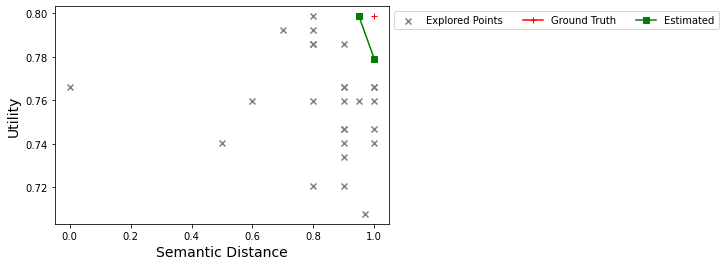

In [12]:
# plot scatter plot of utility and semantic metric for each cluster
import matplotlib.cm as cm
def plot_pareto_points(pareto_points:List, est_pareto_points:List, explored_points:List=None, points_df=None) -> Tuple:
    """
    Plot the estimated and ground truth Pareto fronts.
    Args:
        pareto_points (List): Ground truth Pareto front
        est_pareto_points (List): Estimated Pareto front
    """
    # Sort the points for plotting
    pareto_points = sorted(pareto_points, key=lambda x: x[0])
    est_pareto_points = sorted(est_pareto_points, key=lambda x: x[0])
    # Plot the Pareto front
    pareto_points = np.array(pareto_points)
    est_pareto_points = np.array(est_pareto_points)
    #datapoints = np.array(datapoints)
    # Set size of the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    #f, ax = plt.subplots()
    #ax.scatter(datapoints[0], datapoints[1], c='gray', label='Data Points', alpha=0.3)
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
    colors = cm.rainbow(np.linspace(0, 1, len(points_df['Cluster'].unique())))
    #for cluster in points_df['Cluster'].unique():
    #    cluster_points = points_df[points_df['Cluster'] == cluster]
    #    marker_index = int(cluster % len(markers))
    #    ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color=colors[cluster], alpha=0.5, marker=markers[marker_index])

    ax.scatter(explored_points[0], explored_points[1], c='gray', label='Explored Points', marker='x',)
    ax.plot(pareto_points[:, 0], pareto_points[:, 1], '+-', c='red', label='Ground Truth')
    ax.plot(est_pareto_points[:, 0], est_pareto_points[:, 1], 's-', c='green', label='Estimated')
    ax.legend(bbox_to_anchor=(1, 1),ncol=3)
    ax.set_xlabel('Semantic Distance', fontsize=14)
    ax.set_ylabel('Utility', fontsize=14)
    #ax.set_title('Pareto Curve Estimated vs. Ground-Truth', fontsize=14)
    return fig, ax

fig, ax = plot_pareto_points(gt_pareto_points, est_pareto_points, explored_points, points_df)
plt.show()

In [35]:
def explainable_modeling_multi_attrs(data, y_col, partition_dict) -> float:
    """
    Wrapper function to model the data using an explainable model
    ***** Note: This function is only used in demo_data_modeling_case.ipynb for now *****
    :param data: DataFrame
    :param y_col: str
    :param partition_dict: Dict[str, Partition]
    :return: float
    """
    start_time = time.time()
    
    for attr, partition in partition_dict.items():
        #print(f"Discretizing {attr}...")
        data[attr + '.binned'] = pd.cut(data[attr], bins=partition, labels=False)
        data[attr + '.binned'] = data[attr + '.binned'].astype('float64')
        data = data.dropna(subset=[attr + '.binned'])
    
    
    # Evaluate the explainable model
    X_cols = [col for col in data.columns if col != y_col and col not in list(partition_dict.keys())]
    X = data[X_cols]
    y = data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a decision tree model
    model = DecisionTreeClassifier(random_state=0, max_depth=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)

    #partition.f_time.append((partition.ID, 'utility_comp', time.time() - start_time))
    #partition.utility = model_accuracy
    return model_accuracy

In [53]:
# Exhausitve search for the pareto curve partitions
data = pd.read_csv(os.path.join(ppath, 'data', 'pima', f'diabetes.csv'))
data = data[["Age", "Glucose", "BMI", "Outcome"]]
data = data.dropna()
for partition_dict in partition_dicts:
    data_i = data.copy()
    utility_score = explainable_modeling_multi_attrs(data_i, 'Outcome', partition_dict["Partition"])
    partition_dict["Partition"] = [partition_dict["Partition"]["Age"], partition_dict["Partition"]["Glucose"], partition_dict["Partition"]["BMI"]]
    partition_dict["Utility"] = utility_score
    print(partition_dict)
    print(utility_score)

{'Partition': [array([20., 34., 47., 60.]), array([ -1.  ,   9.95,  49.75,  59.7 ,  69.65,  79.6 ,  89.55,  99.5 ,
       109.45, 119.4 , 129.35, 139.3 , 149.25, 159.2 , 169.15, 179.1 ,
       189.05, 199.  ]), array([-1. , 26.3, 68.1])], 'Semantic': 0.06666666666666664, 'Utility': 0.785234899328859}
0.785234899328859
{'Partition': [array([20., 34., 47., 60.]), array([ -1.  ,   9.95,  49.75,  59.7 ,  69.65,  79.6 ,  89.55,  99.5 ,
       109.45, 119.4 , 129.35, 139.3 , 149.25, 159.2 , 169.15, 179.1 ,
       189.05, 199.  ]), array([-1. , 26.3, 32.8, 68.1])], 'Semantic': 0.06666666666666664, 'Utility': 0.7986577181208053}
0.7986577181208053
{'Partition': [array([20., 34., 47., 60.]), array([ -1.  ,   9.95,  49.75,  59.7 ,  69.65,  79.6 ,  89.55,  99.5 ,
       109.45, 119.4 , 129.35, 139.3 , 149.25, 159.2 , 169.15, 179.1 ,
       189.05, 199.  ]), array([-1. , 18.5, 25. , 30. , 68. ])], 'Semantic': 0.3333333333333333, 'Utility': 0.785234899328859}
0.785234899328859
{'Partition': [array(

In [48]:
# turn partition_dicts into a dataframe
partition_df = pd.DataFrame(partition_dicts, index=None)
partition_df

,Partition,Semantic,Utility
0,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.066667,0.785235
1,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.066667,0.798658
2,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.333333,0.785235
3,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 49.75, 99.5,...",0.250000,0.818792
4,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 49.75, 99.5,...",0.250000,0.818792
...,...,...,...
67,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.500000,0.727273
68,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.766667,0.746753
69,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.733333,0.707792
70,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.733333,0.701299


In [49]:
datapoints = [np.array(partition_df['Semantic'].values), np.array(partition_df['Utility'].values)]
lst = compute_pareto_front(datapoints)
partition_df["Estimated"] = 0
partition_df.loc[lst, "Estimated"] = 1
partition_df["Explored"] = 1
partition_df

,Partition,Semantic,Utility,Estimated,Explored
0,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.066667,0.785235,0,1
1,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.066667,0.798658,0,1
2,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 9.95, 49.75,...",0.333333,0.785235,0,1
3,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 49.75, 99.5,...",0.250000,0.818792,1,1
4,"[[20.0, 34.0, 47.0, 60.0], [-1.0, 49.75, 99.5,...",0.250000,0.818792,1,1
...,...,...,...,...,...
67,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.500000,0.727273,0,1
68,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.766667,0.746753,0,1
69,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.733333,0.707792,0,1
70,"[[-1.0, 18.0, 35.0, 45.0, 65.0, 100.0], [-1.0,...",0.733333,0.701299,0,1


In [50]:
# save partition_df to JSON file
partition_df.to_json(f'modeling_{semantic_metric}.json', orient='records')